In [1]:
import gym
from gym import spaces
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from collections import deque
import cv2
import math
import copy
import pickle
import time
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
import pandas as pd
import seaborn as sns 
import random
import time

cv2.ocl.setUseOpenCL(False)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
env = gym.make("Taxi-v3").env
env.render()
plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/MDP', bbox_inches='tight')
plt.show()

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+



<Figure size 432x288 with 0 Axes>

# Functions

In [4]:
def unbiased(Q, current_index, current_reservoir, max_reservoir_size):
  
  # This is the simple "Algorithm R"

  ## Inputs:
  ### Q is the observation, for example: Q = 1.3
  ### current_index is the number of Qs the algorithm has processed before. Starts at 0.
  ### current_reservoir is a list with the observations that are in the reservoir. Starts empty.
  ### max_reservoir_size is the number of observations we want in the reservoir by the end of the steam (said number might not be reached if the stream is not long enough)

  ## Outputs:
  ### an updated reservoir, that is, an unbiased list of observations of Q

  # 1. If the reservoir is not full yet, add the observation to it:
  if max_reservoir_size > current_index:
      current_reservoir.append(Q)
  
  # 2. If it's not full:
  else: 
    # 2.1. Draw a number from a uniform distribution between 0 and 1:
    draw = random.random()
    # 2.2. With probability 1/(number of observations seen) add the observation to the pool and remove an existing one randomly:
    if draw < 1 / (current_index + 1):
      remove = random.randint(0, max_reservoir_size - 1)
      current_reservoir[remove] = Q
    else: pass
  
  return current_reservoir


In [5]:
def exp_biased(Q, current_reservoir, max_reservoir_size, prob_of_adding_Qt):
  
  # 1. This first if-clause is here to consider the deterministic case, where we could avoid drawing one of the 3 random numbers and save a bit of computing.
  if prob_of_adding_Qt != 1:
  
  # 1.1. Roll the dice to see if we add the observation to the pool:
    draw = random.random()
  
  # 1.2. If we do add it:
    if draw <= prob_of_adding_Qt:

      # 1.2.1. Roll the dice to see if we will also remove an old observation from the pool:
      # The probability of removing an observation is F(t), that is the proportion of the reservoir that's filled:
      second_draw = random.random()
      
      # 1.2.1.1. If we do remove an old observation:
      if second_draw <= len(current_reservoir)/max_reservoir_size:
        # the entry to remove is selected uniformly randomly:
        remove = random.randint(0, len(current_reservoir) - 1)
        current_reservoir.pop(remove)
      
      #1.2.2. Now add Q:
      current_reservoir.append(Q)
  
  # 2. If we deterministically add Q to the reservoir:
  else:
    # 2.1. Roll the dice to see if we will also remove an old observation from the pool:
    # The probability of removing an observation is F(t), that is the proportion of the reservoir that's filled:
    second_draw = random.random()
    
    # 2.2.1. If we do remove an old observation:
    if second_draw <= len(current_reservoir)/max_reservoir_size:
      # the entry to remove is selected uniformly randomly:
      remove = random.randint(0, len(current_reservoir) - 1)

      current_reservoir.pop(remove)
    
    #2.2. Now add Q:
    current_reservoir.append(Q)

  return current_reservoir


In [6]:
def ssw(Q, current_index, current_reservoir, max_reservoir_size, 
        window_size, replacements_list):
  
  if current_index == 0:
    replacements_list = list(np.random.choice(window_size, max_reservoir_size, replace = False))
    new_replacement_list = replacements_list.copy()

  if current_index in replacements_list:
    if len(current_reservoir) < max_reservoir_size:
      if current_index == 0:
        new_reservoir = [Q]
      else:
        current_reservoir.append(Q)
        new_reservoir = current_reservoir
    
    else:
      current_reservoir[replacements_list.index(current_index)] = Q
      new_reservoir = current_reservoir
    
    replacements_list[replacements_list.index(current_index)] = current_index + window_size
    new_replacement_list = replacements_list

  else:
    new_reservoir = current_reservoir
    new_replacement_list = replacements_list

  return new_reservoir, new_replacement_list





In [7]:
def sw_empty(Q, current_index, window_size):
# if the reservoir is empty:

  # 1. Add Q to the reservoir w.p. min(t, w)/w:
  draw = random.random()
  if draw <= (min(current_index + 1, window_size) / window_size):
    reservoir_obs = Q

    # 2. Select the index that will eventually replace the recently added observation:
    replacing_index = random.randint(current_index + 1, current_index + window_size)

  else:
    reservoir_obs = None
    replacing_index = None

  return reservoir_obs, replacing_index

In [8]:
def sw_full(Q, current_index, window_size, current_reservoir_obs, current_replacing_index):
  if current_index == current_replacing_index:
    new_reservoir_obs = Q
    new_replacing_index = random.randint(current_index + 1, current_index + window_size)
  else:
    new_reservoir_obs = current_reservoir_obs
    new_replacing_index = current_replacing_index
  
  return new_reservoir_obs, new_replacing_index

In [9]:
def csw(Q, current_index, current_reservoir, max_reservoir_size, 
       window_size, replacements_list):
  
  new_reservoir = []
  new_replacement_list = []

  current_reservoir_size = len(current_reservoir)

  # for every observation currently in the reservoir and its associated replacing index:
  for (current_reservoir_obs, current_replacing_index) in list(zip(current_reservoir, replacements_list)):
    new_reservoir_obs, new_replacing_index = sw_full(Q, current_index, window_size, current_reservoir_obs, current_replacing_index)
    new_reservoir.append(new_reservoir_obs)
    new_replacement_list.append(new_replacing_index)

  # for every missing observation to complete the max reservoir size:
  for i in range(max_reservoir_size - current_reservoir_size):
    reservoir_obs, replacing_index = sw_empty(Q, current_index, window_size)
    if reservoir_obs is None:
      pass
    else:
      new_reservoir.append(reservoir_obs)
      new_replacement_list.append(replacing_index)      
  
  return new_reservoir, new_replacement_list



In [10]:
def rs(method, Q, current_reservoir, max_reservoir_size, # these parameters are needed for all 3 algorithms
       current_index = 0, # specific to the unbiased version and the sliding window
       window_size = 100, replacements_list = [], # these 2 parameters are specific to the sliding window algorithm
       prob_of_adding_Qt = 1): # this parameter is specific to exponential biased rs

  if method == "unbiased":
    new_reservoir = unbiased(Q, current_index, current_reservoir, max_reservoir_size)
    new_replacements_list = None # the vanilla method doesn't need to keep track of the replacement list

  elif method == "complex sw":
    new_reservoir, new_replacements_list = csw(Q, current_index, current_reservoir, max_reservoir_size, 
                                              window_size, replacements_list)
        
  elif method == "simple sw":
    new_reservoir, new_replacements_list = ssw(Q, current_index, current_reservoir, max_reservoir_size,         
                                              window_size, replacements_list)

  elif method == "exp biased":
    new_reservoir = exp_biased(Q, current_reservoir, max_reservoir_size, prob_of_adding_Qt)
    new_replacements_list = None # the exponentially biased method doesn't need to keep track of the replacement list

  else: print("error 404: method not found")

  return new_reservoir, new_replacements_list

In [11]:
def define_action(observation_t_1,last_policy,q_table,method):

  ### Get index for the new sta
  if method=='sample':
    values=range(env.action_space.n)
    probs=list(last_policy[observation_t_1])
    action=np.random.choice(a=values,size=1,p=probs)[0]

  if method=='greedy': 
    action= np.argmax(q_table[observation_t_1])
  return action 

In [12]:
def get_average(reservoir): 
  acum=reservoir[0]
  for i in range(1,len(reservoir)):
    acum=acum+reservoir[i]
  average=acum/len(reservoir)
  return average



In [13]:
def find_policy(q_total,theta,env):
  new_policy_table=np.full((env.observation_space.n, env.action_space.n), 1/(env.action_space.n))
  for  i in range(q_total.shape[0]):
    ### if the number is too big define a number to minus
    if (any(x>=600 for x in [theta*h for h in q_total[i]])) and not((any(x<=-600 for x in [theta*h for h in q_total[i]]))):
      num=np.max([h for h in q_total[i]])
    elif any(x<=-600 for x in [theta*h for h in q_total[i]]) and not(any(x>=600 for x in [theta*h for h in q_total[i]])):
      num=np.min([h for h in q_total[i]])
    else: 
      num=0
    total=sum([math.exp(theta*(n-num)) for n in q_total[i]])
    for j in range(q_total.shape[1]):      
      new_policy_table[i][j]=math.exp(theta*(q_total[i][j]-num))/total
  return new_policy_table


In [14]:
def evaluate(q_table_param): 

  """Evaluate agent's performance after Q-learning"""

  total_epochs, total_penalties,total_reward = 0, 0,0
  episodes = 100

  for _ in range(episodes):
      state = env.reset()
      epochs, penalties, reward = 0, 0, 0
      
      done = False
      
      while (not done) and (epochs<=100):
          action = np.argmax(q_table_param[state])
          state, reward, done, info = env.step(action)
          total_reward=total_reward+reward
          if reward == -10:
              penalties += 1

          epochs += 1

      total_penalties += penalties
      total_epochs += epochs

  return (total_reward/episodes,total_penalties / episodes,total_epochs / episodes)

In [15]:
### Find Politex Withour Reservoir Sampling 
def politex_2(alpha,gamma,theta):

  q_table = np.zeros([env.observation_space.n, env.action_space.n])
  q_total = q_table
  policy_table= np.full((env.observation_space.n, env.action_space.n), 1/(env.action_space.n))

  # For plotting metrics
  all_epochs = []
  all_rewards=[]
  all_penalties = []
  all_time=[]
  all_space=[]

  for i in range(1, 100):
      start_time = time.time()
      state = env.reset()

      epochs, penalties, reward, = 0, 0, 0
      done = False
      
      while not done:
        
          action = define_action(state,policy_table,q_table,'sample')

          next_state, reward, done, info = env.step(action) 
          
          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])
          
          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          if reward == -10:
              penalties += 1

          state = next_state
          epochs += 1

      # Refresh Totals From Q  
      if i==1:
        q_total=q_table
      else: 
        q_total=(q_total*(i-1)+q_table)/i

      # Find new policy
      policy_table=find_policy(q_total,theta,env)
      
      end_time = time.time()
      if i % 5 == 0:
          dif_time=end_time - start_time
          all_time.append(dif_time)
          clear_output(wait=True)
          total_reward,penalties,epochs=evaluate(q_table)
    
          ### Save metrics 
          all_rewards.append(total_reward)
          all_penalties.append(penalties)
          all_epochs.append(epochs)
          all_space.append(i)


  print("Training finished.\n")

  return (q_table,all_epochs,all_rewards,all_penalties,all_time,all_space)


In [16]:
### This function apply TD Lambda to find the optimal policy for some given hyperparameters
### Since this is a control MDP we already know the optimal average epochs is 14, we stop the iteration at that point to measure performance
### This function return the iteration when the optimal is reached and the Q_table
def q_learning(alpha_param,gamma_param,epsilon_param):

  %%time
  '''Training the agent'''
  '''
  @alpha_param: this is the lambda of TD lambda 
  @gamma_param: this is the discount factor 
  @epsilon_param: this is the treshold set for exploration 
  ''' 
  q_table = np.zeros([env.observation_space.n, env.action_space.n])
  # Hyperparameters
  alpha = alpha_param
  gamma = gamma_param
  epsilon = epsilon_param

  # For plotting metrics
  all_epochs = []
  all_rewards=[]
  all_penalties = []
  all_time=[]
  all_space=[]

  for i in range(1, 100):
      start_time = time.time()
      state = env.reset()

      epochs, penalties, reward, = 0, 0, 0
      done = False
      
      while not done:
          if random.uniform(0, 1) < epsilon:
              action = env.action_space.sample() # Explore action space
          else:
              action = np.argmax(q_table[state]) # Exploit learned values

          next_state, reward, done, info = env.step(action) 
          
          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])
          
          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          if reward == -10:
              penalties += 1

          state = next_state
          epochs += 1
      
      end_time = time.time()
      if i % 5 == 0:
          
          dif_time=end_time - start_time
          all_time.append(dif_time)

          clear_output(wait=True)
          total_reward,penalties,epochs=evaluate(q_table)
    
          ### Save metrics 
          all_rewards.append(total_reward)
          all_penalties.append(penalties)
          all_epochs.append(epochs)
          all_space.append(1)

          
  print("Training finished.\n")
  return (q_table,all_epochs,all_rewards,all_penalties,all_time,all_space)

In [17]:
def reservoir_sampling(method,alpha,gamma,theta,max_reservoir_size,window_size):

  q_table = np.zeros([env.observation_space.n, env.action_space.n])
  ### List of reservoir Qs
  q_total = []
  ### List of indexes for sliding window
  index_list=[]

  policy_table= np.full((env.observation_space.n, env.action_space.n), 1/(env.action_space.n))
  %%time
  """Training the agent"""

  # For plotting metrics
  all_epochs = []
  all_rewards=[]
  all_penalties = []
  all_time=[]
  all_space=[]

  for i in range(1, 100):
      start_time = time.time()
      state = env.reset()

      epochs, penalties, total_reward, = 0, 0, 0
      done = False
      
      while not done:
        
          action = define_action(state,policy_table,q_table,'sample')

          next_state, reward, done, info = env.step(action) 
          
          old_value = q_table[state, action]
          next_max = np.max(q_table[next_state])
          
          new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
          q_table[state, action] = new_value

          if reward == -10:
              penalties += 1

          state = next_state
          epochs += 1



      # Apply reservoir sampling to the entire table  
      q_total,index_list=rs(method, q_table, q_total, max_reservoir_size, # these parameters are needed for all 3 algorithms
       current_index = i-1, # specific to the unbiased version and the sliding window
       window_size = window_size, replacements_list = index_list, # these 2 parameters are specific to the sliding window algorithm
       prob_of_adding_Qt = 1)
      ### if the reservoir doesnt give a reservoir play random until it gets at leat one 
      if len(q_total)==0: 
        q_avg=np.zeros([env.observation_space.n, env.action_space.n])
      else: 
        q_avg=get_average(q_total)
      # Find new policy
      policy_table=find_policy(q_avg,theta,env)
      end_time = time.time()
      
      if i % 5 == 0:
          dif_time=end_time - start_time
          all_time.append(dif_time)
          clear_output(wait=True)
          print(f"Episode: {i}")
          total_reward,penalties,epochs=evaluate(q_table)

          ### Save metrics 
          all_rewards.append(total_reward)
          all_penalties.append(penalties)
          all_epochs.append(epochs)
          all_space.append(len(q_total))

  #print("Training finished.\n")

  return (q_table,all_epochs,all_rewards,all_penalties,all_time,all_space)

# Simulations

### Unbiased Reservoir Sampling

In [18]:
results=pd.DataFrame()
for i in range(2,15,1):
  temp_results=pd.DataFrame()
  final_q,epochs,rewards,penalties,time_r,space=reservoir_sampling('unbiased',0.5	,1,0.01,i,None)
  temp_results['epochs']=epochs
  temp_results['rewards']=rewards
  temp_results['penalties']=penalties
  temp_results['N']=i
  temp_results['time']=time_r
  temp_results['space']=space
  results=results.append(temp_results)


Episode: 95


### Sliding Window Reservoir Sampling

In [19]:
results_csw=pd.DataFrame()
for j in [5,30,80]:
  for i in range(int(j/5),int(4*j/5),(int(j/5))):
    temp_results_csw=pd.DataFrame()
    final_csw,epochs_csw,rewards_csw,penalties_csw,time_r_csw,space_csw=reservoir_sampling('simple sw',0.5	,1,0.01,i,j)
    temp_results_csw['epochs']=epochs_csw
    temp_results_csw['rewards']=rewards_csw
    temp_results_csw['penalties']=penalties_csw
    temp_results_csw['N']=i
    temp_results_csw['Window']=j
    temp_results_csw['time']=time_r_csw
    temp_results_csw['space']=space_csw
    results_csw=results_csw.append(temp_results_csw)

Episode: 95


### Exponentialy Biased Reservoir Sampling

In [20]:
results_eb=pd.DataFrame()
for j in [0.1,0.2,0.3,0.9]:
  temp_results_eb=pd.DataFrame()
  final_eb,epochs_eb,rewards_eb,penalties_eb,time_r_eb,space_eb=reservoir_sampling('exp biased',0.5	,1,0.01,int(1/j),None)
  temp_results_eb['epochs']=epochs_eb
  temp_results_eb['rewards']=rewards_eb
  temp_results_eb['penalties']=penalties_eb
  temp_results_eb['N']=int(1/j)
  temp_results_eb['lmbda']=j
  temp_results_eb['time']=time_r_eb
  temp_results_eb['space']=space_eb
  results_eb=results_eb.append(temp_results_eb)

Episode: 95


### Politex 

In [21]:
results_politex=pd.DataFrame()
final_q_p,epochs_p,rewards_p,penalties_p,time_p,space_p=politex_2(0.5,1,0.01)
results_politex['epochs']=epochs_p
results_politex['rewards']=rewards_p
results_politex['penalties']=penalties_p
results_politex['time']=time_p
results_politex['space']=space_p

Training finished.



### Epsilon Greedy 

In [22]:
results_epsilon=pd.DataFrame()
final_q_e,epochs_e,rewards_e,penalties_e,time_e,space_e=q_learning(1,0.8,0.1)
results_epsilon['epochs']=epochs_e
results_epsilon['rewards']=rewards_e
results_epsilon['penalties']=penalties_e
results_epsilon['time']=time_e
results_epsilon['space']=space_e

Training finished.



# Visualization

In [23]:
plt.style.use('bmh')

## Unbiased

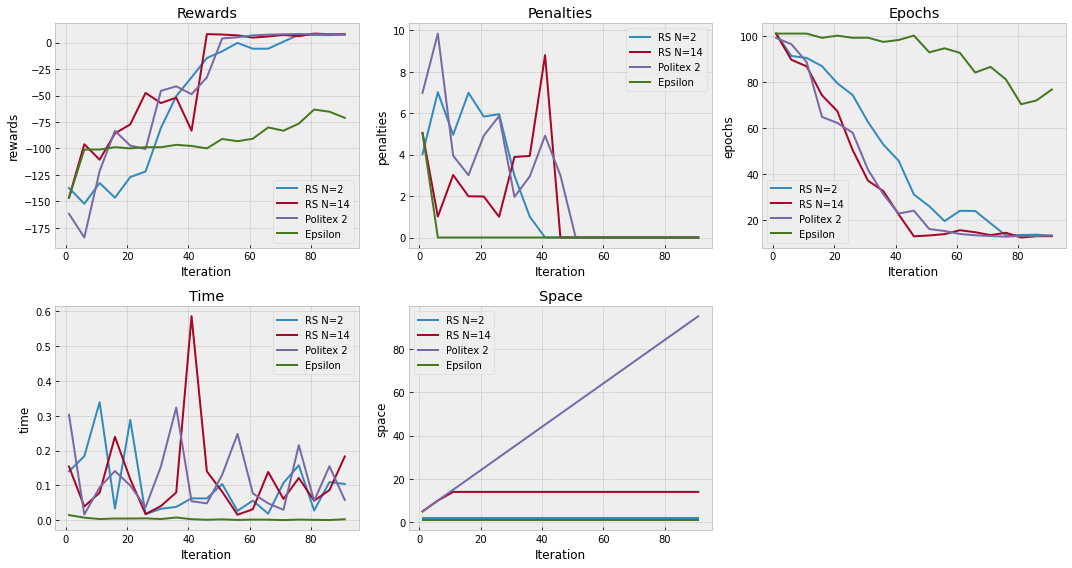

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

axs[0][0].set_title('Rewards')
axs[0][0].set_xlabel('Iteration')
for i in [2,14]:
  temp=results[results['N']==i].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="rewards",label='RS N='+str(i),ax=axs[0][0])
sns.lineplot(data=results_politex, x=range(1,95,5), y="rewards",label='Politex 2',ax=axs[0][0])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="rewards",label='Epsilon',ax=axs[0][0])
axs[0][0].legend(loc="lower right")

axs[0][1].set_title('Penalties')
axs[0][1].set_xlabel('Iteration')
for i in [2,14]:
  temp=results[results['N']==i].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="penalties",label='RS N='+str(i),ax=axs[0][1])
sns.lineplot(data=results_politex, x=range(1,95,5), y="penalties",label='Politex 2',ax=axs[0][1])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="penalties",label='Epsilon',ax=axs[0][1])

axs[0][2].set_title('Epochs')
axs[0][2].set_xlabel('Iteration')
for i in [2,14]:
  temp=results[results['N']==i].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="epochs",label='RS N='+str(i),ax=axs[0][2])
sns.lineplot(data=results_politex, x=range(1,95,5), y="epochs",label='Politex 2',ax=axs[0][2])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="epochs",label='Epsilon',ax=axs[0][2])

axs[1][0].set_title('Time')
axs[1][0].set_xlabel('Iteration')
for i in [2,14]:
  temp=results[results['N']==i].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="time",label='RS N='+str(i),ax=axs[1][0])
sns.lineplot(data=results_politex, x=range(1,95,5), y="time",label='Politex 2',ax=axs[1][0])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="time",label='Epsilon',ax=axs[1][0])

axs[1][1].set_title('Space')
axs[1][1].set_xlabel('Iteration')
for i in [2,14]:
  temp=results[results['N']==i].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="space",label='RS N='+str(i),ax=axs[1][1])
sns.lineplot(data=results_politex, x=range(1,95,5), y="space",label='Politex 2',ax=axs[1][1])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="space",label='Epsilon',ax=axs[1][1])


axs[1][2].set_visible(False)
fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/visulization/Unbiased.png', bbox_inches='tight')
plt.show()

## Sliding Window

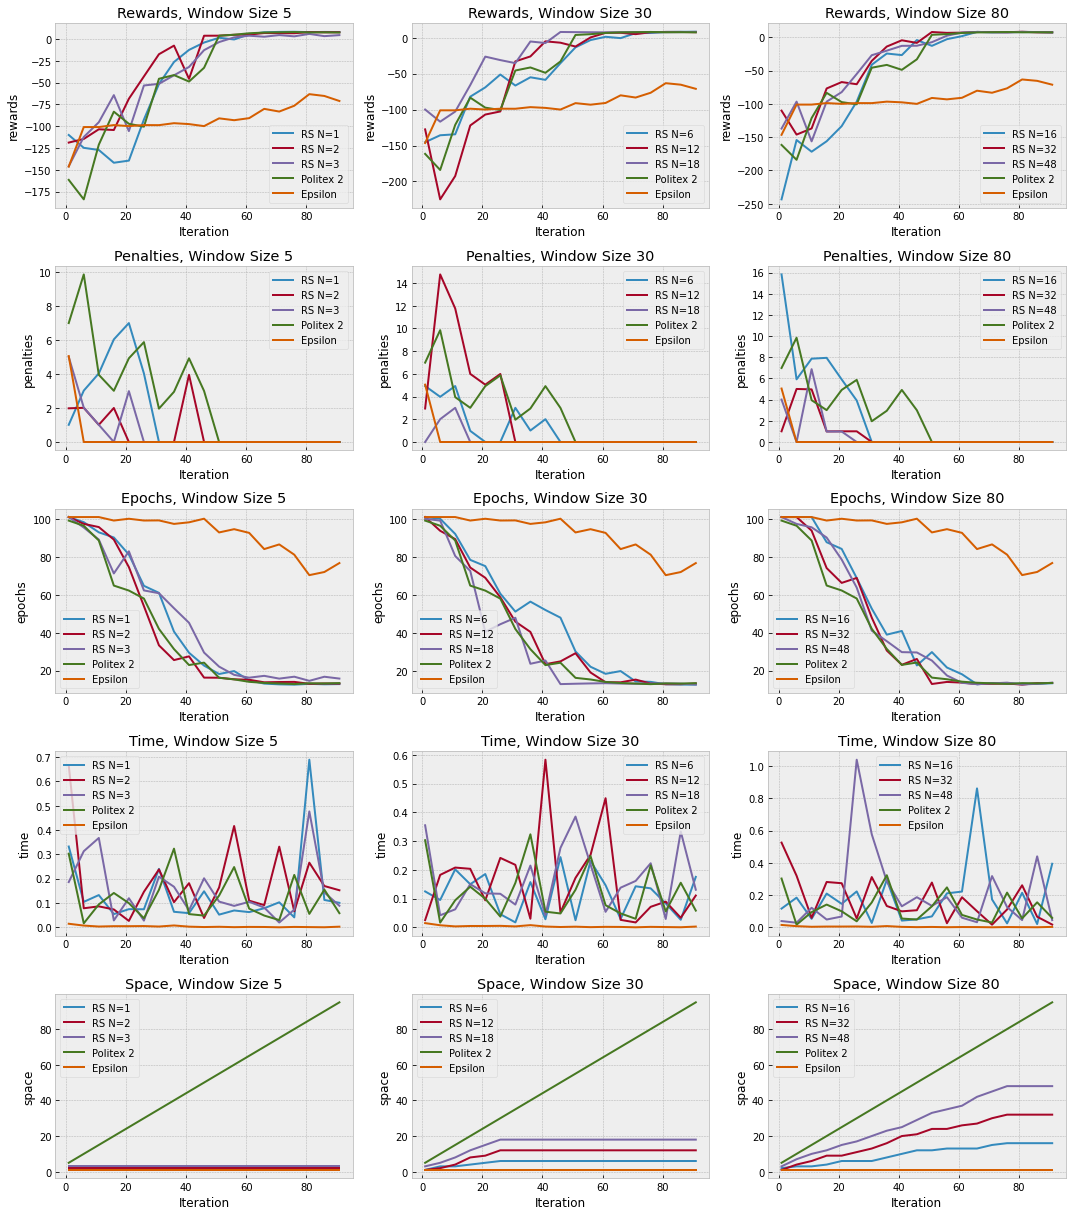

In [25]:
fig, axs = plt.subplots(5, 3, figsize=(15, 17), sharey=False)

for i,j in enumerate(list(results_csw['Window'].value_counts().index)):
  axs[0][i].set_title('Rewards, Window Size '+str(j))
  axs[0][i].set_xlabel('Iteration')
  for k in list(results_csw[results_csw['Window']==j]['N'].value_counts().index):
    temp=results_csw[(results_csw['Window']==j)&(results_csw['N']==k)].reset_index()
    sns.lineplot(data=temp, x=range(1,95,5), y="rewards",label='RS N='+str(k),ax=axs[0][i])
  sns.lineplot(data=results_politex, x=range(1,95,5), y="rewards",label='Politex 2',ax=axs[0][i])
  sns.lineplot(data=results_epsilon, x=range(1,95,5), y="rewards",label='Epsilon',ax=axs[0][i])
  axs[0][i].legend(loc="lower right")

for i,j in enumerate(list(results_csw['Window'].value_counts().index)):
  axs[1][i].set_title('Penalties, Window Size '+str(j))
  axs[1][i].set_xlabel('Iteration')
  for k in list(results_csw[results_csw['Window']==j]['N'].value_counts().index):
    temp=results_csw[(results_csw['Window']==j)&(results_csw['N']==k)].reset_index()
    sns.lineplot(data=temp, x=range(1,95,5), y="penalties",label='RS N='+str(k),ax=axs[1][i])
  sns.lineplot(data=results_politex, x=range(1,95,5), y="penalties",label='Politex 2',ax=axs[1][i])
  sns.lineplot(data=results_epsilon, x=range(1,95,5), y="penalties",label='Epsilon',ax=axs[1][i])

for i,j in enumerate(list(results_csw['Window'].value_counts().index)):
  axs[2][i].set_title('Epochs, Window Size '+str(j))
  axs[2][i].set_xlabel('Iteration')
  for k in list(results_csw[results_csw['Window']==j]['N'].value_counts().index):
    temp=results_csw[(results_csw['Window']==j)&(results_csw['N']==k)].reset_index()
    sns.lineplot(data=temp, x=range(1,95,5), y="epochs",label='RS N='+str(k),ax=axs[2][i])
  sns.lineplot(data=results_politex, x=range(1,95,5), y="epochs",label='Politex 2',ax=axs[2][i])
  sns.lineplot(data=results_epsilon, x=range(1,95,5), y="epochs",label='Epsilon',ax=axs[2][i])

for i,j in enumerate(list(results_csw['Window'].value_counts().index)):
  axs[3][i].set_title('Time, Window Size '+str(j))
  axs[3][i].set_xlabel('Iteration')
  for k in list(results_csw[results_csw['Window']==j]['N'].value_counts().index):
    temp=results_csw[(results_csw['Window']==j)&(results_csw['N']==k)].reset_index()
    sns.lineplot(data=temp, x=range(1,95,5), y="time",label='RS N='+str(k),ax=axs[3][i])
  sns.lineplot(data=results_politex, x=range(1,95,5), y="time",label='Politex 2',ax=axs[3][i])
  sns.lineplot(data=results_epsilon, x=range(1,95,5), y="time",label='Epsilon',ax=axs[3][i])

for i,j in enumerate(list(results_csw['Window'].value_counts().index)):
  axs[4][i].set_title('Space, Window Size '+str(j))
  axs[4][i].set_xlabel('Iteration')
  for k in list(results_csw[results_csw['Window']==j]['N'].value_counts().index):
    temp=results_csw[(results_csw['Window']==j)&(results_csw['N']==k)].reset_index()
    sns.lineplot(data=temp, x=range(1,95,5), y="space",label='RS N='+str(k),ax=axs[4][i])
  sns.lineplot(data=results_politex, x=range(1,95,5), y="space",label='Politex 2',ax=axs[4][i])
  sns.lineplot(data=results_epsilon, x=range(1,95,5), y="space",label='Epsilon',ax=axs[4][i])


fig.tight_layout()
plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/visulization/Sliding Window.png', bbox_inches='tight')
plt.show()

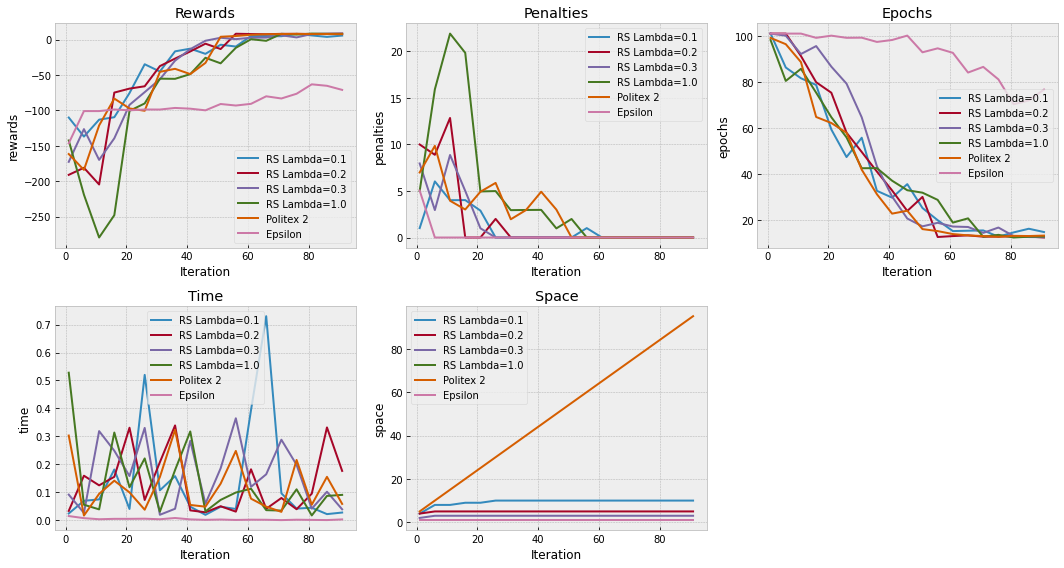

In [26]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

axs[0][0].set_title('Rewards')
axs[0][0].set_xlabel('Iteration')

for k in list(results_eb['N'].value_counts().index):
  temp=results_eb[results_eb['N']==k].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="rewards",label='RS Lambda='+str(1/k)[0:3],ax=axs[0][0])
sns.lineplot(data=results_politex, x=range(1,95,5), y="rewards",label='Politex 2',ax=axs[0][0])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="rewards",label='Epsilon',ax=axs[0][0])
axs[0][0].legend(loc="lower right")


axs[0][1].set_title('Penalties')
axs[0][1].set_xlabel('Iteration')

for k in list(results_eb['N'].value_counts().index):
  temp=results_eb[results_eb['N']==k].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="penalties",label='RS Lambda='+str(1/k)[0:3],ax=axs[0][1])
sns.lineplot(data=results_politex, x=range(1,95,5), y="penalties",label='Politex 2',ax=axs[0][1])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="penalties",label='Epsilon',ax=axs[0][1])

axs[0][2].set_title('Epochs')
axs[0][2].set_xlabel('Iteration')

for k in list(results_eb['N'].value_counts().index):
  temp=results_eb[results_eb['N']==k].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="epochs",label='RS Lambda='+str(1/k)[0:3],ax=axs[0][2])
sns.lineplot(data=results_politex, x=range(1,95,5), y="epochs",label='Politex 2',ax=axs[0][2])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="epochs",label='Epsilon',ax=axs[0][2])

axs[1][0].set_title('Time')
axs[1][0].set_xlabel('Iteration')

for k in list(results_eb['N'].value_counts().index):
  temp=results_eb[results_eb['N']==k].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="time",label='RS Lambda='+str(1/k)[0:3],ax=axs[1][0])
sns.lineplot(data=results_politex, x=range(1,95,5), y="time",label='Politex 2',ax=axs[1][0])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="time",label='Epsilon',ax=axs[1][0])


axs[1][1].set_title('Space')
axs[1][1].set_xlabel('Iteration')

for k in list(results_eb['N'].value_counts().index):
  temp=results_eb[results_eb['N']==k].reset_index()
  sns.lineplot(data=temp, x=range(1,95,5), y="space",label='RS Lambda='+str(1/k)[0:3],ax=axs[1][1])
sns.lineplot(data=results_politex, x=range(1,95,5), y="space",label='Politex 2',ax=axs[1][1])
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="space",label='Epsilon',ax=axs[1][1])


fig.tight_layout()
axs[1][2].set_visible(False)
plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/visulization/Exponentially Biased.png', bbox_inches='tight')
plt.show()

## Comparison 

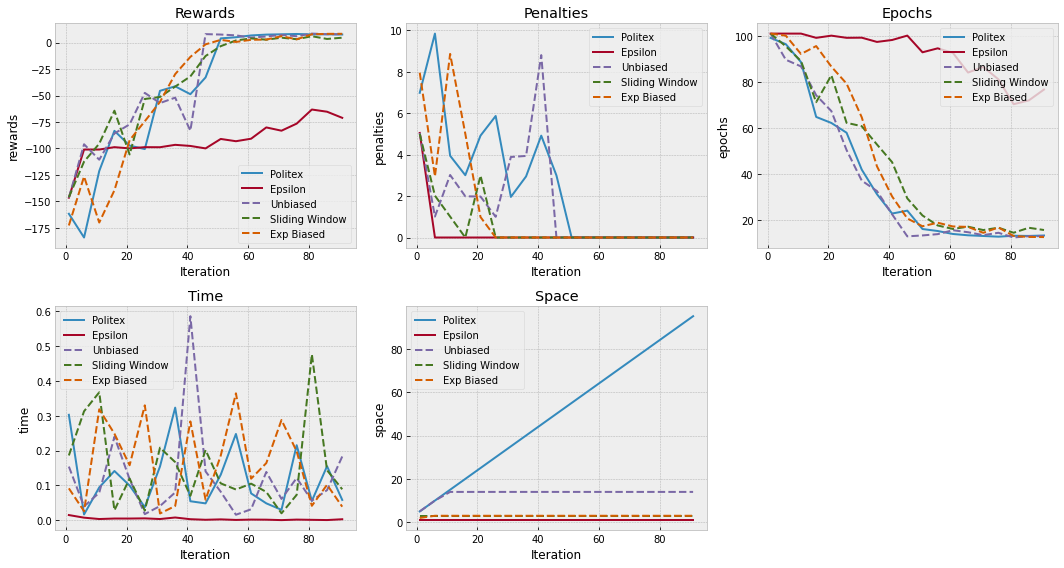

In [27]:
fig, axs = plt.subplots(2, 3, figsize=(15, 8), sharey=False)

### Reward Comparison 
axs[0][0].set_title('Rewards')
axs[0][0].set_xlabel('Iteration')

# Politex Results
sns.lineplot(data=results_politex, x=range(1,95,5), y="rewards",label='Politex',ax=axs[0][0])
# Greedy Results
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="rewards",label='Epsilon',ax=axs[0][0])
# Unbiased Results
temp=results[results['N']==14].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="rewards",label='Unbiased',ax=axs[0][0],linestyle='--')
# Sliding Window Results
temp=results_csw[(results_csw['Window']==5)&(results_csw['N']==3)].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="rewards",label='Sliding Window',ax=axs[0][0],linestyle='--')
# Exponentially Biased Results
temp=results_eb[results_eb['N']==3].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="rewards",label='Exp Biased',ax=axs[0][0],linestyle='--')
axs[0][0].legend(loc="lower right")

### Penalties Comparison 
axs[0][1].set_title('Penalties')
axs[0][1].set_xlabel('Iteration')

# Politex Results
sns.lineplot(data=results_politex, x=range(1,95,5), y="penalties",label='Politex',ax=axs[0][1])
# Greedy Results
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="penalties",label='Epsilon',ax=axs[0][1])
# Unbiased Results
temp=results[results['N']==14].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="penalties",label='Unbiased',ax=axs[0][1],linestyle='--')
# Sliding Window Results
temp=results_csw[(results_csw['Window']==5)&(results_csw['N']==3)].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="penalties",label='Sliding Window',ax=axs[0][1],linestyle='--')
# Exponentially Biased Results
temp=results_eb[results_eb['N']==3].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="penalties",label='Exp Biased',ax=axs[0][1],linestyle='--')
axs[0][1].legend(loc="upper right")


### Epochs Comparison 
axs[0][2].set_title('Epochs')
axs[0][2].set_xlabel('Iteration')

# Politex Results
sns.lineplot(data=results_politex, x=range(1,95,5), y="epochs",label='Politex',ax=axs[0][2])
# Greedy Results
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="epochs",label='Epsilon',ax=axs[0][2])
# Unbiased Results
temp=results[results['N']==14].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="epochs",label='Unbiased',ax=axs[0][2],linestyle='--')
# Sliding Window Results
temp=results_csw[(results_csw['Window']==5)&(results_csw['N']==3)].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="epochs",label='Sliding Window',ax=axs[0][2],linestyle='--')
# Exponentially Biased Results
temp=results_eb[results_eb['N']==3].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="epochs",label='Exp Biased',ax=axs[0][2],linestyle='--')
axs[0][2].legend(loc="upper right")

### Time Comparison 
axs[1][0].set_title('Time')
axs[1][0].set_xlabel('Iteration')

# Politex Results
sns.lineplot(data=results_politex, x=range(1,95,5), y="time",label='Politex',ax=axs[1][0])
# Greedy Results
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="time",label='Epsilon',ax=axs[1][0])
# Unbiased Results
temp=results[results['N']==14].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="time",label='Unbiased',ax=axs[1][0],linestyle='--')
# Sliding Window Results
temp=results_csw[(results_csw['Window']==5)&(results_csw['N']==3)].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="time",label='Sliding Window',ax=axs[1][0],linestyle='--')
# Exponentially Biased Results
temp=results_eb[results_eb['N']==3].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="time",label='Exp Biased',ax=axs[1][0],linestyle='--')
axs[1][0].legend(loc="upper right")

### Time Comparison 
axs[1][1].set_title('Space')
axs[1][1].set_xlabel('Iteration')

# Politex Results
sns.lineplot(data=results_politex, x=range(1,95,5), y="space",label='Politex',ax=axs[1][1])
# Greedy Results
sns.lineplot(data=results_epsilon, x=range(1,95,5), y="space",label='Epsilon',ax=axs[1][1])
# Unbiased Results
temp=results[results['N']==14].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="space",label='Unbiased',ax=axs[1][1],linestyle='--')
# Sliding Window Results
temp=results_csw[(results_csw['Window']==5)&(results_csw['N']==3)].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="space",label='Sliding Window',ax=axs[1][1],linestyle='--')
# Exponentially Biased Results
temp=results_eb[results_eb['N']==3].reset_index()
sns.lineplot(data=temp, x=range(1,95,5), y="space",label='Exp Biased',ax=axs[1][1],linestyle='--')
axs[1][0].legend(loc="upper left")

fig.tight_layout()
axs[1][2].set_visible(False)
plt.savefig('/content/drive/MyDrive/Classroom/21D000 - DSM Master Project 21-22 DSM T3/visulization/Comparison.png', bbox_inches='tight')
plt.show()


## Play The Game

In [28]:
### Visualization of the optimal policy 
state = env.reset()
epochs, penalties, reward = 0, 0, 0

done = False

while not done:
    env.render()
    action = np.argmax(final_eb[state])
    state, reward, done, info = env.step(action)

    if reward == -10:
      penalties += 1

    epochs += 1

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+

+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (South)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (Pickup)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B:_|
+---------+
  (East)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | :_|
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : :_|
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : :_|
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
+---------+
|R: | : :G|
| : | : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
  (North)
